# Nazario EDA and Preprocessing

## 1 Import libraries

In [1]:
print("Loading libraries...")

# Core libraries
import os
import pandas as pd
import numpy as np
import re # For regular expressions
import time # To time operations
import gdown
import ast

# Email parsing
import email
from email import policy
from email.parser import BytesParser, Parser
from email.utils import parsedate_to_datetime, getaddresses

# HTML processing
from bs4 import BeautifulSoup

# Text processing
import unicodedata

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_columns', 50)

print("Libraries imported.\n")

Loading libraries...
Libraries imported.



## 2 Load raw Nazario data

In [2]:
NAZARIO_CSV_GDRIVE_FILE_ID = '1T41EN9aBljruMd5Yq0jWPsi1vbFlZFNg'
NAZARIO_CSV_LOCAL_FILENAME = 'nazario_5.csv'
gdrive_url_nazario_csv = f'https://drive.google.com/uc?id={NAZARIO_CSV_GDRIVE_FILE_ID}'

if not os.path.exists(NAZARIO_CSV_LOCAL_FILENAME):
    print(f"Downloading {NAZARIO_CSV_LOCAL_FILENAME} from Google Drive...")

    try:
        gdown.download(gdrive_url_nazario_csv, NAZARIO_CSV_LOCAL_FILENAME, quiet=False)
        print(f"{NAZARIO_CSV_LOCAL_FILENAME} downloaded successfully.")

    except Exception as e:
        print(f"ERROR downloading {NAZARIO_CSV_LOCAL_FILENAME}: {e}. Check File ID and share settings.")

else:
    print(f"{NAZARIO_CSV_LOCAL_FILENAME} already exists in Colab runtime.")

# Use the downloaded/local file
NAZARIO_CSV_INPUT_PATH = NAZARIO_CSV_LOCAL_FILENAME

# Initialise
df_nazario_raw = pd.DataFrame()

if os.path.exists(NAZARIO_CSV_INPUT_PATH):
    try:
        df_nazario_raw = pd.read_csv(NAZARIO_CSV_INPUT_PATH, encoding='latin1')
        print(f"Successfully loaded {NAZARIO_CSV_INPUT_PATH}. Shape: {df_nazario_raw.shape}")
        print("\nRaw Nazario CSV head:")
        print(df_nazario_raw.head())
        print("\nRaw Nazario CSV info:")
        df_nazario_raw.info(show_counts=True)

    except Exception as e:
        print(f"Error loading {NAZARIO_CSV_INPUT_PATH}: {e}")

else:
    print(f"ERROR: {NAZARIO_CSV_INPUT_PATH} not found after download attempt.")

Downloading...
From: https://drive.google.com/uc?id=1T41EN9aBljruMd5Yq0jWPsi1vbFlZFNg
To: /content/nazario_5.csv
100%|██████████| 11.8M/11.8M [00:00<00:00, 50.8MB/s]


nazario_5.csv downloaded successfully.
Successfully loaded nazario_5.csv. Shape: (3065, 7)

Raw Nazario CSV head:
                                                      sender  \
0                         "Hu, Sylvia" <Sylvia.Hu@ENRON.com>   
1                           "Webb, Jay" <Jay.Webb@ENRON.com>   
2                       "Symms, Mark" <Mark.Symms@ENRON.com>   
3                     "Thorne, Judy" <Judy.Thorne@ENRON.com>   
4  "Williams, Jason R (Credit)" <Jason.R.Williams@ENRON.com>   

                                                                                                                                                receiver  \
0  "Acevedo, Felecia" <Felecia.Acevedo@ENRON.com>, "Brown, MeCole" <MeCole.Brown@ENRON.com>, "Cash, Michelle" <Michelle.Cash@ENRON.com>, "Castellano,...   
1                                                                                                               "Lambie, Chris" <Chris.Lambie@ENRON.com>   
2                                

## 3 Initial Data Exploration (EDA)

The CSV has been loaded. We have identified the following key columns: 'sender', 'receiver', 'date', 'subject', 'body', 'label' (0 or 1), and 'urls' (array).

1. Confirm these columns and their data types.
2. Investigate the 'label' column. Since Nazario is a phishing corpus, we expect most/all to be phishing (label 1). If there are 0s, we need to understand what they represent in this specific CSV.
3. Examine the 'urls' column format.
4. Check for missing values.

In [3]:
TEXT_COLUMN_NAME_NAZARIO = 'body'
SUBJECT_COLUMN_NAME_NAZARIO = 'subject'
LABEL_COLUMN_NAME_NAZARIO = 'label'
URLS_COLUMN_NAME_NAZARIO = 'urls'

if not df_nazario_raw.empty:
    print("--- Column Names Confirmed ---")
    print(df_nazario_raw.columns.tolist())

    print(f"\nUsing text (body) column: '{TEXT_COLUMN_NAME_NAZARIO}'")
    print(f"Using subject column: '{SUBJECT_COLUMN_NAME_NAZARIO}'")
    print(f"Using label column: '{LABEL_COLUMN_NAME_NAZARIO}'")
    print(f"Using URLs column: '{URLS_COLUMN_NAME_NAZARIO}'")

    print(f"\n--- Data Types ---")
    print(df_nazario_raw.dtypes)

    print(f"\n--- Missing Values per Column ---")
    print(df_nazario_raw.isnull().sum())

    # Drop rows where essential columns for our purpose (body, subject, label) are missing
    essential_cols_nazario = [TEXT_COLUMN_NAME_NAZARIO, SUBJECT_COLUMN_NAME_NAZARIO, LABEL_COLUMN_NAME_NAZARIO]
    df_nazario_raw.dropna(subset=essential_cols_nazario, inplace=True)
    print(f"\nShape after dropping NaNs in essential columns: {df_nazario_raw.shape}")

    print(f"\n--- Value Counts for Label Column ('{LABEL_COLUMN_NAME_NAZARIO}') ---")
    print(df_nazario_raw[LABEL_COLUMN_NAME_NAZARIO].value_counts(dropna=False))

    print(f"\n--- EDA for 'urls' column ('{URLS_COLUMN_NAME_NAZARIO}') ---")

    if URLS_COLUMN_NAME_NAZARIO in df_nazario_raw.columns:
        # Convert string representation of list to actual list if needed
        # This is a common issue with CSVs storing list-like data
        # For now, let's just see some raw values and non-null counts
        print(f"Sample values from '{URLS_COLUMN_NAME_NAZARIO}' column:")
        print(df_nazario_raw[URLS_COLUMN_NAME_NAZARIO].dropna().sample(min(5, len(df_nazario_raw[URLS_COLUMN_NAME_NAZARIO].dropna()))).tolist())
        df_nazario_raw['has_urls_in_col'] = df_nazario_raw[URLS_COLUMN_NAME_NAZARIO].notna() & (df_nazario_raw[URLS_COLUMN_NAME_NAZARIO].astype(str).str.len() > 2) # Check for non-empty lists like '[]'
        print(f"\nCounts for '{URLS_COLUMN_NAME_NAZARIO}' presence (heuristic):")
        print(df_nazario_raw['has_urls_in_col'].value_counts())

    else:
        print(f"'{URLS_COLUMN_NAME_NAZARIO}' column not found.")


    print(f"\n--- Example Text from Body Column ('{TEXT_COLUMN_NAME_NAZARIO}') (first 300 chars) ---")

    if not df_nazario_raw[TEXT_COLUMN_NAME_NAZARIO].empty:
        for content in df_nazario_raw[TEXT_COLUMN_NAME_NAZARIO].sample(min(3, len(df_nazario_raw))).astype(str):
            print(content[:300])
            print("-" * 30)

    else:
        print(f"No non-missing values found in the text column '{TEXT_COLUMN_NAME_NAZARIO}' for sampling.")

    print(f"\n--- Example Subjects from Subject Column ('{SUBJECT_COLUMN_NAME_NAZARIO}') ---")

    if not df_nazario_raw[SUBJECT_COLUMN_NAME_NAZARIO].empty:
        for content in df_nazario_raw[SUBJECT_COLUMN_NAME_NAZARIO].sample(min(3, len(df_nazario_raw))).astype(str):
            print(content)
            print("-" * 30)

    else:
        print(f"No non-missing values found in the subject column '{SUBJECT_COLUMN_NAME_NAZARIO}' for sampling.")

else:
    print("Raw Nazario DataFrame is empty. Skipping EDA.")

--- Column Names Confirmed ---
['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']

Using text (body) column: 'body'
Using subject column: 'subject'
Using label column: 'label'
Using URLs column: 'urls'

--- Data Types ---
sender      object
receiver    object
date        object
subject     object
body        object
label        int64
urls        object
dtype: object

--- Missing Values per Column ---
sender        2
receiver    113
date          3
subject      50
body          0
label         0
urls          0
dtype: int64

Shape after dropping NaNs in essential columns: (3015, 7)

--- Value Counts for Label Column ('label') ---
label
1    1561
0    1454
Name: count, dtype: int64

--- EDA for 'urls' column ('urls') ---
Sample values from 'urls' column:
["['http://www.bbc.co.uk/email', 'http://www.bbc.co.uk/email', 'http://www.bbc.co.uk/email', 'http://www.bbc.co.uk/email/help']", '1', '[]', "['http://xent.com/mailman/listinfo/fork']", "['http://www.nabble.com/Virtual-Co

## 4 Define preprocessing functions

In [4]:
def clean_text_content(text):
    if not isinstance(text, str):
      return ""

    # Step 1: Basic HTML Tag Removal (if CSV text column contains HTML)
    if bool(BeautifulSoup(text, "html.parser").find()):
        soup = BeautifulSoup(text, 'html.parser')

        for script_or_style in soup(["script", "style"]):
            script_or_style.decompose()

        text = soup.get_text(separator=' ', strip=True)

    # Step 2: Text Normalization and Cleaning
    text = unicodedata.normalize('NFKC', text)
    text = text.lower()

    # Remove URLs and email addresses before other punctuation if they are noisy
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', ' ', text)

    # Keep basic punctuation, replace other non-alphanumeric with space
    text = re.sub(r"[^a-zA-Z0-9\s.,!?'\"$%()]", ' ', text)

    # Consolidate multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Strip text
    text = text.strip()

    return text

In [5]:
def parse_url_list_string(url_list_str):
    if pd.isna(url_list_str) or not isinstance(url_list_str, str) or url_list_str in ['[]', '']:
        return []

    try:
        evaluated_list = ast.literal_eval(url_list_str)

        if isinstance(evaluated_list, list):
            return [str(url).strip() for url in evaluated_list if str(url).strip()] # Ensure urls are strings and not empty

        return []

    except (ValueError, SyntaxError):
        # If it's not a perfect list string, try basic splitting if it's just comma-separated
        # This part is heuristic and depends on the actual format of your 'urls' column string

        if isinstance(url_list_str, str) and ',' in url_list_str:
            return [url.strip().strip("'\"") for url in url_list_str.strip("[]").split(',') if url.strip()]

        return []

## 5 Apply preprocessing and label assignment

Clean the 'body' and 'subject' text data.
Parse the 'urls' column into actual lists of URLs.
Convert 'date' column to datetime objects.
Assign label `1` (phishing) to all entries, as Nazario is a phishing corpus. For its role as a *phishing test set*, we'll focus on label 1.

In [6]:
df_processed_nazario = pd.DataFrame()

TEXT_COL = 'body'
SUBJECT_COL = 'subject'
LABEL_COL = 'label'
URLS_COL = 'urls'
DATE_COL = 'date'
SENDER_COL = 'sender'
RECEIVER_COL = 'receiver'

if not df_nazario_raw.empty:
    print(f"Processing Nazario data...")

    # Create a working copy with essential columns
    # Keep original columns for now, select final ones later
    df_temp_nazario = df_nazario_raw.copy()

    # Clean the text columns
    print(f"Cleaning text in '{TEXT_COL}'...")
    start_time = time.time()
    df_temp_nazario['body_cleaned'] = df_temp_nazario[TEXT_COL].astype(str).apply(clean_text_content)

    print(f"Cleaning text in '{SUBJECT_COL}'...")
    df_temp_nazario['subject_cleaned'] = df_temp_nazario[SUBJECT_COL].astype(str).apply(clean_text_content)

    # Parse date column
    if DATE_COL in df_temp_nazario.columns:
        print(f"Parsing '{DATE_COL}' column...")
        df_temp_nazario['datetime_parsed'] = pd.to_datetime(df_temp_nazario[DATE_COL], errors='coerce')

    # Parse URLs column (if it exists and is a string representation of a list)
    if URLS_COL in df_temp_nazario.columns:
        print(f"Parsing '{URLS_COL}' column...")
        df_temp_nazario['urls_list'] = df_temp_nazario[URLS_COL].apply(parse_url_list_string)
        df_temp_nazario['num_urls_extracted'] = df_temp_nazario['urls_list'].apply(len)

    else: # If 'urls' column wasn't what we thought, create placeholders
        df_temp_nazario['urls_list'] = [[] for _ in range(len(df_temp_nazario))]
        df_temp_nazario['num_urls_extracted'] = 0

    end_time = time.time()
    print(f"Text, date, and URL parsing took {end_time - start_time:.2f} seconds.")

    # Handle the 'label' column from CSV
    # Since Nazario is a phishing corpus, we are primarily interested in label 1.
    # If your CSV's 'label' column has 0s, you might want to filter them out or investigate why.
    print(f"\nOriginal label distribution from CSV's '{LABEL_COL}':")
    print(df_temp_nazario[LABEL_COL].value_counts())

    # For this test set's purpose, we will use only the phishing emails.
    # If your label column is already correct (e.g., all 1s, or a mix and you filter), great.
    # If you need to override or select, do it here:
    df_temp_nazario = df_temp_nazario[df_temp_nazario[LABEL_COL] == 1].copy()

    # Confirming our desired label for this test set
    df_temp_nazario['final_label'] = 1

    # Select final columns for the processed dataframe
    cols_to_keep_final = ['body_cleaned', 'subject_cleaned', 'final_label', 'urls_list', 'num_urls_extracted', 'datetime_parsed', SENDER_COL, RECEIVER_COL]

    # Filter to only include columns that actually exist in df_temp_nazario
    existing_cols_to_keep = [col for col in cols_to_keep_final if col in df_temp_nazario.columns]
    df_processed_nazario = df_temp_nazario[existing_cols_to_keep].copy()

    # Standardise label column
    df_processed_nazario.rename(columns={'final_label': 'label'}, inplace=True)

    if not df_processed_nazario.empty:
        print(f"\nProcessed {len(df_processed_nazario)} phishing emails from Nazario.")
        print("Processed Nazario head:")
        print(df_processed_nazario.head())
        print("\nLabel distribution in final processed Nazario data (should be all 1s):")
        print(df_processed_nazario['label'].value_counts(dropna=False))

    else:
        print("No phishing emails (label 1) selected from Nazario after processing. Check label column and filtering.")

else:
    print("Raw Nazario DataFrame is empty. Skipping preprocessing.")

Processing Nazario data...
Cleaning text in 'body'...
Cleaning text in 'subject'...
Parsing 'date' column...
Parsing 'urls' column...
Text, date, and URL parsing took 3.80 seconds.

Original label distribution from CSV's 'label':
label
1    1561
0    1454
Name: count, dtype: int64

Processed 1561 phishing emails from Nazario.
Processed Nazario head:
                                                                                                                                               body_cleaned  \
1500  this text is part of the internal format of your mail folder, and is not a real message. it is created automatically by the mail system software. ...   
1501  business with cpanel whm dear client, our technical services department are carrying out a planned software upgrade. please login to re confirm yo...   
1502  your two incoming mails were placed on pending status due to the recent upgrade in our database, in order to receive the messages kindly click her...   
1503        

<ipython-input-6-820fa4a2ede0>:29: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_temp_nazario['datetime_parsed'] = pd.to_datetime(df_temp_nazario[DATE_COL], errors='coerce')


## 6 Further EDA on processed data

Review characteristics of the cleaned Nazario phishing emails.

--- Descriptive Stats for Processed Nazario ---
       body_cleaned_length  subject_cleaned_length  num_urls_extracted
count         1.561000e+03             1561.000000              1561.0
mean          3.739360e+03               36.664318                 0.0
std           1.091267e+05               24.572578                 0.0
min           0.000000e+00                0.000000                 0.0
25%           3.520000e+02               23.000000                 0.0
50%           6.270000e+02               32.000000                 0.0
75%           1.108000e+03               45.000000                 0.0
max           4.312233e+06              476.000000                 0.0


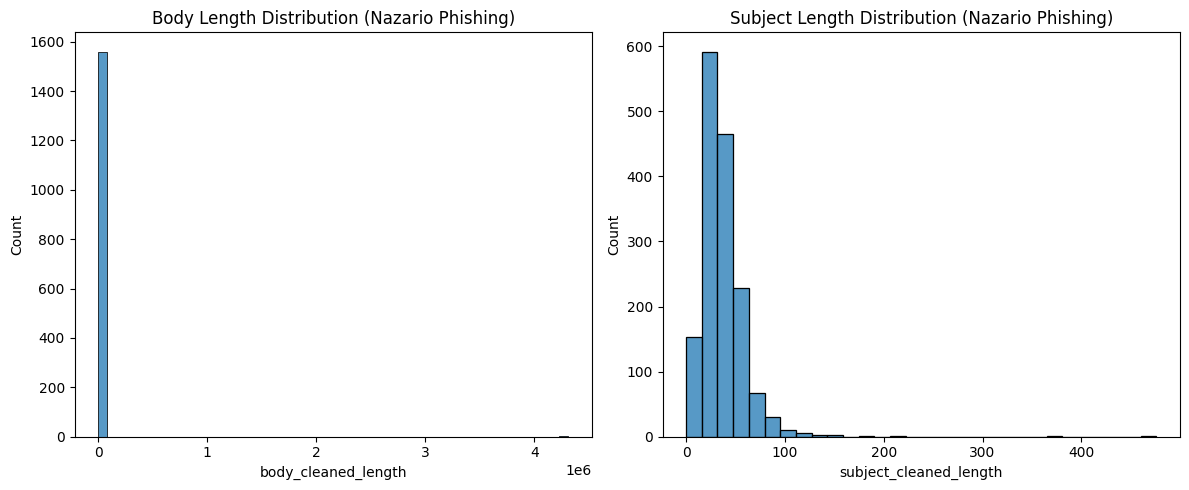


--- EDA for parsed 'urls_list' (if column exists) ---
Number of emails with extracted URLs vs without:
num_urls_extracted
False    1561
Name: count, dtype: int64

Sample of extracted URLs (first URL from emails that have them):


In [7]:
if not df_processed_nazario.empty:
    df_processed_nazario['body_cleaned_length'] = df_processed_nazario['body_cleaned'].astype(str).apply(len)
    df_processed_nazario['subject_cleaned_length'] = df_processed_nazario['subject_cleaned'].astype(str).apply(len)

    print("--- Descriptive Stats for Processed Nazario ---")
    print(df_processed_nazario[['body_cleaned_length', 'subject_cleaned_length', 'num_urls_extracted']].describe())

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data=df_processed_nazario, x='body_cleaned_length', bins=50, kde=False)
    plt.title('Body Length Distribution (Nazario Phishing)')

    plt.subplot(1, 2, 2)
    sns.histplot(data=df_processed_nazario, x='subject_cleaned_length', bins=30, kde=False)
    plt.title('Subject Length Distribution (Nazario Phishing)')
    plt.tight_layout()
    plt.show()

    print(f"\n--- EDA for parsed 'urls_list' (if column exists) ---")

    if 'urls_list' in df_processed_nazario.columns:
        print("Number of emails with extracted URLs vs without:")
        print(df_processed_nazario['num_urls_extracted'].apply(lambda x: x > 0).value_counts())

        # Example of some extracted URLs
        print("\nSample of extracted URLs (first URL from emails that have them):")
        urls_sample = df_processed_nazario[df_processed_nazario['num_urls_extracted'] > 0]['urls_list'].sample(min(5, len(df_processed_nazario[df_processed_nazario['num_urls_extracted'] > 0]))).tolist()

        for url_l in urls_sample:
            # if list is not empty
            if url_l:
                print(url_l[0]) # print first url

else:
    print("Processed Nazario DataFrame is empty.")

## 7 Save processed data

Save the processed Nazario phishing data. This will serve as an independent test set.

In [8]:
if not df_processed_nazario.empty:
    OUTPUT_FILENAME_NAZARIO = f'nazario_phishing_test_processed_{len(df_processed_nazario)}.csv'

    try:
        df_processed_nazario.to_csv(OUTPUT_FILENAME_NAZARIO, index=False) # Saves to /content/
        print(f"Processed Nazario test data saved to Colab runtime at: /content/{OUTPUT_FILENAME_NAZARIO}")

    except Exception as e:
        print(f"Error saving processed Nazario data: {e}")

else:
    print("Processed Nazario DataFrame is empty. Nothing to save.")

Processed Nazario test data saved to Colab runtime at: /content/nazario_phishing_test_processed_1561.csv
IMPORTANT: This file is temporary. Download or save to Google Drive.
